In [ ]:
from nbdev import *

In [ ]:
%nbdev_default_export gen
import numpy as np
import matplotlib.pyplot as plt
try:
    import svgwrite
except:
    !pip install svgwrite
    import svgwrite
from svgwrite import cm, mm
    
try:
    import shapely
except:
    !pip install shapely
    import shapely
from shapely.geometry import LineString, Point
from  functools import partial
%matplotlib inline

In [ ]:
# Basic Line functions

In [ ]:
%nbdev_export
def _get_ax(line):
    """ returns the direction of the line
    [param] line: tuple or np.array of length 4, where 0,1 is point 1 and 3,4 is point 2
    """
    if np.isclose(line[0],line[2]) and line[1] != line[3]:
        return 1
    else:
        return 0

def _line2segmented_pointlist(line, min_tab_mm):
    """
    This fuction splits a line into segments that can be used to generate tabs or holes.
    The min_tab_mm tells the minimum tabsize but might adjusts it a bit larger to always make 
    number of tabs an even number so it's symetrical
    \[param] min_tab_mm
    
    \[return]: list of points, shape (number of segments, 2(x,y))
    """
    line=np.array(line)
    ax = _get_ax(line)
    ay = (ax+1)%2 
    diff =  line[ax+2] - line[ax]
    if diff<0:
        line = line[[2,3,0,1]]
    num_tabs = int(abs(diff/min_tab_mm))
    if num_tabs%2==0:
        num_tabs -=1
    tab_size= abs(diff/num_tabs)
    all_tabs = np.arange(line[ax], line[ax+2]+1, tab_size)
    ret = np.zeros((len(all_tabs),2))
    ret[:,ax] = all_tabs
    ret[:,ay] = line[ay]
    return ret, ax

In [ ]:
assert _get_ax([0,0,200,0]) == 0
assert _get_ax([200,0,0,0]) == 0
assert _get_ax([0,200,0,0]) == 1
assert _get_ax([0,0,0,200]) == 1

In [ ]:
line = [0, 200, 0,0]
segments, ax = _line2segmented_pointlist(line, 15)
assert len(segments)%2==0

segments, ax

(array([[  0.        ,   0.        ],
        [  0.        ,  15.38461538],
        [  0.        ,  30.76923077],
        [  0.        ,  46.15384615],
        [  0.        ,  61.53846154],
        [  0.        ,  76.92307692],
        [  0.        ,  92.30769231],
        [  0.        , 107.69230769],
        [  0.        , 123.07692308],
        [  0.        , 138.46153846],
        [  0.        , 153.84615385],
        [  0.        , 169.23076923],
        [  0.        , 184.61538462],
        [  0.        , 200.        ]]),
 1)

In [ ]:
def plot_lines(lines):
    for l in lines:
        l = l.reshape(2,2)
        plt.plot(l[:,0], l[:,1])

In [ ]:
%nbdev_export
def _segments_to_tabs(segments, ax, tabsize):
    """
    genrates tabs from a segmented point list
    """
    arr_x = np.repeat(segments[:,ax], 2)
    arr_y = np.tile([0,0, tabsize, tabsize], len(segments)//2+1)[1:-3]
    ret = np.zeros((len(arr_x),2))
    ret[:,ax] = arr_x
    ret[:,(ax+1)%2] = arr_y
    points = ret[1:-1,:]
    return np.hstack([points[:-1], points[1:]])

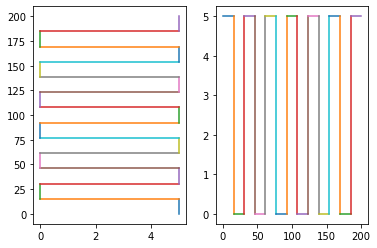

In [ ]:
line = [0, 200, 0,0]
segments, ax = _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, ax, 5)
plt.subplot(1,2,1)
plot_lines(tabs)

line = [ 200,0,  0,0]
segments, ax = _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, ax, 5)
plt.subplot(1,2,2)
plot_lines(tabs)

In [ ]:
%nbdev_export
def _tabs2holes(tabs, ax):
    tabs=tabs.copy()
    to_modify = np.arange(0,len(tabs)-1,4)
    values_from = np.arange(4,len(tabs),4)
    tabs[to_modify,ax] = tabs[values_from,ax]
    return tabs[:-1]

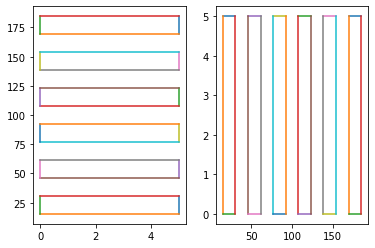

In [ ]:
line = [0, 200, 0,0]
segments, ax = _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, ax, 5)
holes = _tabs2holes(tabs, ax)
plt.subplot(1,2,1)
plot_lines(holes)

line = [ 200,0,  0,0]
segments, ax = _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, ax, 5)
holes = _tabs2holes(tabs, ax)
plt.subplot(1,2,2)
plot_lines(holes)

In [ ]:
class OneLine:
    def __init__(self, line):
        if type(line) is OneLine:
            line = line.line
        self.line = np.array(line,dtype=float)
        self.ax = _get_ax(self.line)
        
    def move_xy(self,x,y):
        self.line +=[x,y,x,y]
        
    def move_in_ax(self, dist):
        self.line[[self.ax, self.ax+2]] += dist
        
    def move_in_ay(self, dist):
        ay = (self.ax+1)%2
        self.line[[ay, ay+2]] += dist
        
    def to_points(self):
        return self.line.reshape(2,2)
    
    def __getitem__(self, key):
        return self.line[key]
    
    def __setitem__(self, key, value):
        self.line[key] = value
        self.ax = _get_ax(self.line)
        
    def __repr__(self):
        return f"l: {self.line}, ax: {self.ax}"
    def copy(self):
        return OneLine(self.line)
        

In [ ]:
class LineObj:
    def __init__(self, lines, ax=None):
        self.lines = np.array(lines, dtype=float)
        self.mx = 0
        self.my = 0
        self.ax=ax
        
    def __getitem__(self, key):
        return self.lines[key]
    
    def __setitem__(self, key, value):
        self.lines[key] = value
        
    @classmethod
    def generate_tabs(cls, line, min_tab_mm, plywood_thick_mm, comp=True):
        if type(line) is OneLine:
            line = line.line
            
        segments, ax = _line2segmented_pointlist(line, min_tab_mm)
        ay = (ax+1)%2
        tabs = _segments_to_tabs(segments, ax, plywood_thick_mm)
        tabs[:,ay] += line[ay]
        tabs[:,ay+2] += line[ay]

        tabs[0,ax] += abs(plywood_thick_mm)*comp
        tabs[-1,ax+2] -= abs(plywood_thick_mm)*comp
        return cls(tabs, ax)
    
    @classmethod
    def generate_holes(cls, line, min_tab_mm, plywood_thick_mm, comp=True):
        """
        
        \[param] comp: True: generates the holes in the middle of the line. otherwize it't on the top of the line
        """
        if type(line) is OneLine:
            line = line.line
            
        segments, ax = _line2segmented_pointlist(line, min_tab_mm)
        ay = (ax+1)%2
        tabs = _segments_to_tabs(segments, ax, plywood_thick_mm)
        tabs = _tabs2holes(tabs, ax)
        # move holes to the position of the line
        tabs[:,ay] += line[ay] - comp* plywood_thick_mm/2   
        tabs[:,ay+2] += line[ay] - comp* plywood_thick_mm/2

        
        return cls(tabs, ax)   
        
    def reset_move(self):
        self.mx=0
        self.my=0
        
    def move_xy(self, x, y):
        self.lines += [x,y,x,y]
        self.mx +=x
        self.my +=y
        
    def move_in_ax(self, dist):
        self.lines[:,[self.ax, self.ax+2]] += dist
        if self.ax==0:
            self.mx+=dist
        else:
            self.my+=dist
    def move_in_ay(self, dist):
        ay  = (self.ax+1)%2
        self.lines[:,[ay, ay+2]] += dist
        if self.ax==0:
            self.my+=dist
        else:
            self.mx+=dist
        
    def plot(self):
        for l in self.lines:
            l = l.reshape(2,2)
            plt.plot(l[:,0], l[:,1])

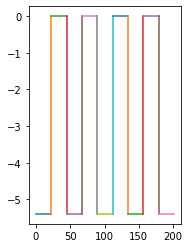

In [ ]:
line = [201.4, 0, 0,0]
llist = LineObj.generate_tabs(line, min_tab_mm=20.3, plywood_thick_mm=-5.4, comp=False)

plt.subplot(1,2,1)
llist.plot()


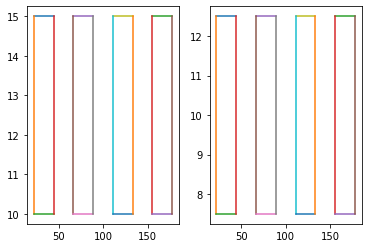

In [ ]:
line = [200, 10, 0,10]
llist2 = LineObj.generate_holes(line, min_tab_mm=20, plywood_thick_mm=5, comp=False)
plt.subplot(1,2,1)
llist2.plot()

line = [200, 10, 0,10]
llist2 = LineObj.generate_holes(line, min_tab_mm=20, plywood_thick_mm=5, comp=True)
plt.subplot(1,2,2)
llist2.plot()

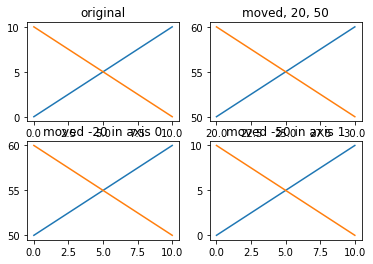

In [ ]:
lines=[[0,0, 10,10],
       [0,10,10,0]]

x , y = 20,50
lobj = LineObj(lines,ax=0)
plt.subplot(2,2,1)
plt.title('original')
lobj.plot()
assert lobj.mx == 0
assert lobj.my == 0

plt.subplot(2,2,2)
plt.title(f"moved, {x}, {y}")
lobj.move_xy(x,y)
lobj.plot()
assert lobj.mx == 20
assert lobj.my == 50

plt.subplot(2,2,3)
plt.title(f"moved -{x} in axis 0")
lobj.move_in_ax(-x)
lobj.plot()
assert lobj.mx == 0
assert lobj.my == 50

plt.subplot(2,2,4)
plt.title(f"moved -{y} in axis 1")
lobj.move_in_ay(-y)
lobj.plot()

assert lobj.mx == 0
assert lobj.my == 0

In [ ]:
def check_intersection(side1, side2):
    if side1.x_dir == side2.x_dir:
        # no intersection since they are paralell
        return
    

In [ ]:
%nbdev_export
class Side:
    def __init__(self, line, height, min_tab_size, thick):
        if type(line) is OneLine:
            line = line.line
        self.min_tab_size = min_tab_size
        self.thick = thick
        self.x_dir = _get_ax(line)
        self.y_dir = (self.x_dir+1)%2
        self.height = height
        
        self.mx, self.my = 0,0
        # generates the lines as a rectangle
        self.base = np.array(line, dtype=float)
        self.l = np.array([line[0],line[1], line[0],line[1] ], dtype=float)
        self.l[2+self.y_dir] += height
        self.r = np.array([line[2], line[3], line[2], line[3]], dtype=float)
        self.r[2+self.y_dir] += height
        self.t =np.array([self.l[2], self.l[3], self.r[2], self.r[3]], dtype=float)
        self.result = None
    
        
    def generate_bottomside(self):
        bottom = LineObj.generate_tabs(self.base, self.min_tab_size, self.thick)
        top = LineObj.generate_tabs(self.t, self.min_tab_size, -self.thick)
        left = LineObj.generate_tabs(self.l, self.min_tab_size, self.thick)
        right = LineObj.generate_tabs(self.r, self.min_tab_size, -self.thick)
        self.result = np.vstack([bottom.lines, 
                                 top.lines,
                                 left.lines,
                                 right.lines])
    
    def generate_outer_wall(self):  
        holes = LineObj.generate_holes(self.base, self.min_tab_size, self.thick, comp=False)
        holes.move_in_ay(self.thick)  
        d = 1 if self.x_dir==0 else -1
        left = LineObj.generate_tabs(self.l, self.min_tab_size, d*self.thick, comp=False)
        right = LineObj.generate_tabs(self.r, self.min_tab_size, -d*self.thick, comp=False)
        top = self.t.copy()
        base = self.base.copy()
        if self.x_dir:
            right.move_in_ay(-self.thick)
            left.move_in_ay( self.thick)
        else:
            top += [self.thick, 0, -self.thick,0]
            base +=[self.thick, 0, -self.thick,0]
        self.result = np.vstack([holes.lines, 
                                 left.lines,
                                 right.lines, 
                                 top, 
                                 base])
        
    def add_holes(self, line):
        line = OneLine(line)
        line.move_xy(self.mx, self.my)
        holes = LineObj.generate_holes(line, self.min_tab_size, self.thick, comp=True)
        self.result = np.vstack([self.result, holes.lines])
        
    def generate_inner_wall(self):
        # this one is a bit tricy since the floor has an offset to the rest of the walls.
        # we first generate the sides as usual but then move the top base and top line
        # and also need to trim the end of the lines 
        tabs1 = LineObj.generate_tabs(self.base, self.min_tab_size, self.thick, comp=True)
        tabs1.move_in_ay(self.thick)
        tabs2 = LineObj.generate_tabs(self.l, self.min_tab_size, self.thick, comp=False)
        tabs2[0, self.y_dir] += self.thick*2
        tabs2[-1, self.y_dir+2] += self.thick
        
        tabs3 = LineObj.generate_tabs(self.r, self.min_tab_size, -self.thick, comp=False)
        tabs3[0, self.y_dir] += self.thick*2
        tabs3[-1, self.y_dir+2] += self.thick
        
        top = OneLine(self.t)
        top.move_in_ay(self.thick)        
        self.result = np.vstack([tabs1.lines, tabs2.lines, tabs3.lines,top.line ])
        
    def flip_h(self):
        self.result[:,[0,2]] = -self.result[:,[0,2]] + np.max(self.result[:,[0,2]])
        
    def flip_v(self):
        self.result[:,[1,3]] = -self.result[:,[1,3]] + np.max(self.result[:,[1,3]])
        
    def move(self, x, y):
        self.mx +=x
        self.my +=y
        self.result += [x,y,x,y]
        
    def plot_outline(self):
        lines = np.array([self.base, self.l, self.r, self.t])
        plot_lines(lines)
        
    def plot(self):
        plot_lines(self.result)
        
    def add_inner_walls(self,other_side):
        if other_side.x_dir == self.x_dir:
            #lines are paralell, we don't make any more comparisons
            return  # they do not intersect
        myline = LineString(self.base.reshape(2,2))
        oline = LineString(other_side.base.reshape(2,2))
        pint = myline.intersection(oline)
        try:
            p = pint.x, pint.y
            i_line = OneLine([p[0],
                      p[1],
                      p[0],
                      p[1]])
            i_line[self.y_dir] = 0
            i_line[self.y_dir+2] = self.height
          
        except:
            # we didn't find any intersection
            return 
        
        ps = self.base.reshape(2,2)
        any(np.isclose(ps,p).sum(axis=1)==2)
        if any(np.isclose(ps,p).sum(axis=1)==2):
            # return if intersection is our own endpoint
            return
        print(f"intersection point: {p}, line {other_side.base}")
        ps = other_side.base.reshape(2,2)
        any(np.isclose(ps,p).sum(axis=1)==2)
        if any(np.isclose(ps,p).sum(axis=1)==2):
            print("endpoint found")
            # Endpoint, we shoud generate holes in our self
            holes = LineObj.generate_holes(i_line, self.min_tab_size, self.thick, comp=True)
            holes.move_in_ax(-self.thick)
            x = np.min(self.result[:,[0,2]])
            y = np.min(self.result[:,[1,3]])
            holes.move_xy(x,y)
            self.result =np.vstack([self.result, holes.lines])
        else:
            print('intersection found')
            i_line.move_in_ax(self.thick)
            l1, l2 = i_line.copy(), i_line.copy()
            # split the lines
            l1.move_in_ay(-self.thick/2)
            l2.move_in_ay(self.thick/2)
            x =np.min(self.result[:,[0,2]])
            y =np.min(self.result[:,[1,3]])
            l1.move_xy(x,y)
            l2.move_xy(x,y)

            if i_line.ax==1:
                dim = 0
                d= -1
            else:
                dim = 2
                d = 1
            half = self.height/2
            l1[self.y_dir+dim] -=d*half
            l2[self.y_dir+dim] -=d*half
            l1[[self.x_dir, self.x_dir+2]]
            l2[[self.x_dir, self.x_dir+2]]
            x = np.min(self.result[:,[0,2]])
            y = np.min(self.result[:,[1,3]])

            if self.x_dir==1:
                l1.move_xy(-self.thick,0)
                l2.move_xy(-self.thick,0)
                l3 = OneLine([l1[self.y_dir+dim],
                      l1[self.x_dir+dim],
                      l2[self.y_dir+dim],
                      l2[self.x_dir+dim]])
            else:
                l1.move_xy(0, -self.thick)
                l2.move_xy(0, -self.thick)
                l3 = OneLine([l1[self.x_dir+dim],
                      l1[self.y_dir+dim],
                      l2[self.x_dir+dim],
                      l2[self.y_dir+dim]])
            
            slitz = np.vstack([l1.line, l2.line, l3.line])
            #slitz += [self.mx, self.my, self.mx, self.my]
            self.result =np.vstack([self.result, slitz])

intersection point: (0.0, 100.0), line [-10. 100. 200. 100.]
intersection found
intersection point: (100.0, 0.0), line [100. -10. 100. 200.]
intersection found


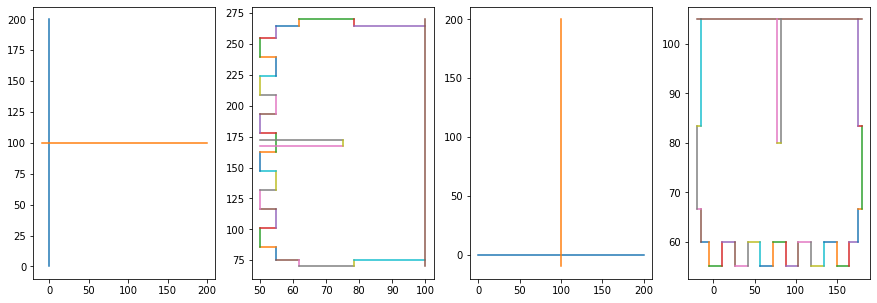

In [ ]:
line1 = np.array([0,0, 0,200])
line2 = np.array([-10, 100, 200, 100])
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plot_lines(np.array([line1, line2]))
tab_sz =15
th = 5
s1 = Side(line1, 50,tab_sz, th)
s2 = Side(line2, 50, tab_sz, th)

s1.generate_inner_wall()
s1.move(45,70)
s1.add_inner_walls(s2)
plt.subplot(1,4,2)
s1.plot()

line1 = np.array([0,0, 200,0])
line2 = np.array([100, -10, 100, 200])
plt.subplot(1,4,3)
plot_lines(np.array([line1, line2]))

s1 = Side(line1, 50,tab_sz, th)
s2 = Side(line2, 50, tab_sz, th)

s1.generate_inner_wall()
s1.move(-20,50)
s1.add_inner_walls(s2)
plt.subplot(1,4,4)
s1.plot()

intersection point: (0.0, 100.0), line [  0. 100. 200. 100.]
endpoint found


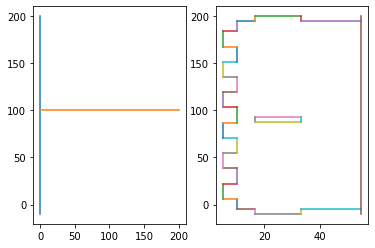

In [ ]:
line1 = np.array([0,-10, 0,200])
line2 = np.array([0, 100, 200, 100])
plt.figure()
plt.subplot(1,2,1)
plot_lines(np.array([line1, line2]))

s1 = Side(line1, 50,15,5)
s2 = Side(line2, 50,15, 5)

s1.generate_inner_wall()
s1.add_inner_walls(s2)
plt.subplot(1,2,2)
s1.plot()


# Inner walls + Holes example

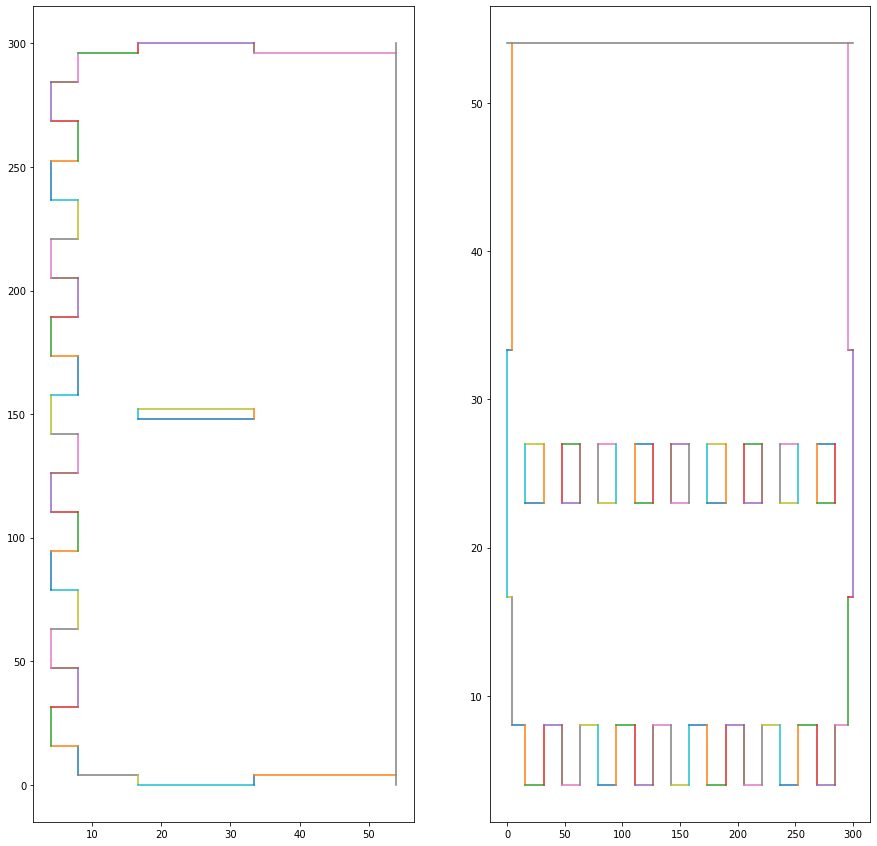

In [ ]:

l = [0,0, 0, 300]
line = [0,150, 50,150]
s = Side(l, 50, min_tab_size=15, thick=4)
s.generate_inner_wall()
s.add_holes(line)
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
s.plot()

l = [0,0, 300, 0]
line = [0,25, 300,25]
s = Side(l, 50,min_tab_size=15, thick=4 )
s.generate_inner_wall()
s.add_holes(line)
plt.subplot(1,2,2)
s.plot()

# Outer walls example

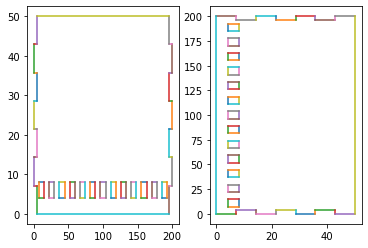

In [ ]:
l = [0, 0, 200, 0]
s = Side(l, 50,7,4)
s.generate_outer_wall()
plt.subplot(1,2,1)
s.plot()

l = [0, 0, 0, 200]
s = Side(l, 50,7,4)
s.generate_outer_wall()
plt.subplot(1,2,2)
s.plot()

# Bottom Side example

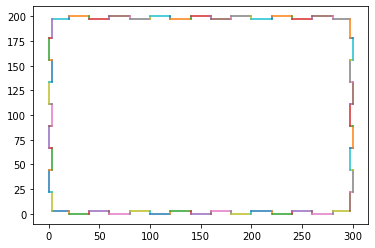

In [ ]:
l = [0,0,300,0]
tab_size = 20
thick = 3
s = Side(l, 200, tab_size, thick)
s.generate_bottomside()
s.plot()

# Box Generator

In [ ]:
%nbdev_export
def gen_points(x, y):
    return [0,0], [0, y], [x, y ], [x, 0]

class BoxGen:
    def __init__(self, 
                 playwood_thickness,
                x_size_mm, y_size_mm,
                height_mm,
                min_tabsize_mm=30):
        self.thickness = playwood_thickness
        self.x = x_size_mm
        self.y = y_size_mm
        self.height = height_mm
        self.min_tabsize = min_tabsize_mm
        bottom_line = [0,0, x_size_mm, 0 ]
        self.bottom = Side(bottom_line, y_size_mm, min_tabsize_mm, playwood_thickness)
        self.bottom.generate_bottomside()
        
        lr_line = [0,0,0, y_size_mm]
        left =  Side(lr_line, height_mm, min_tabsize_mm, playwood_thickness)
        left.generate_outer_wall()
        left.move(-height_mm, 0)
        
        right =  Side(lr_line, height_mm, min_tabsize_mm, playwood_thickness)
        right.generate_outer_wall()
        right.move(-height_mm*2,0)
        
        
        ul_line = [0,0,x_size_mm, 0]
        upper =  Side(ul_line, height_mm,min_tabsize_mm, playwood_thickness)
        upper.generate_outer_wall()
        upper.move(0,-height_mm)
        
        lower = Side(ul_line, height_mm,min_tabsize_mm, playwood_thickness)
        lower.generate_outer_wall()
        lower.move(0,-height_mm*2)
        
        self.outer_walls = [left, right, upper, lower]
        self.inner_walls = list()
        
    
    def plot_outline(self):
        p1,p2,p3,p4 =gen_points(self.x, self.y)
        lines = np.array([p1 + p2, p2+p3, p3+p4, p4+p1])
        plot_lines(lines)
        for s in self.inner_walls:
            plot_lines([s.base])

        
    def add_innerwall(self, p1,p2):
        line = OneLine(p1+p2)
        iwall = Side(line, self.height,self.min_tabsize, self.thickness)
        iwall.generate_inner_wall()
        
        self.bottom.add_holes(line)

        num = len([s for s in self.inner_walls if s.x_dir==iwall.x_dir])
        #else:
        x_start = np.min(iwall.result[:,0])
        y_start = np.min(iwall.result[:,1])
        x,y = -x_start, -y_start        ## hur många
        if iwall.x_dir==0:
            y+= num*self.height + self.y
        else:
            x+= num *self.height + self.x
        
        print(x,y)
            
        iwall.move(x,y)
        self.inner_walls.append(iwall)
        for owall in self.outer_walls:
            owall.add_inner_walls(iwall)
            
    def update_inner_walls(self):
        for s1 in self.inner_walls:
            for s2 in self.inner_walls:
                if s1 is s2:
                    continue
                else:
                    print(s1.base, s2.base)
                    s1.add_inner_walls(s2)
        
    def plot(self):
        self.bottom.plot()
        for i, s in enumerate(self.outer_walls):
            s.plot()
            
        for s in self.inner_walls:
            s.plot()
    
    @staticmethod
    def to_dwg(obj, dwg):
        for r in obj.result:
            dwg.add(dwg.line((r[0]*mm,r[1]*mm),(r[2]*mm,r[3]*mm), stroke="#000"))
        
    def export_to_svg(self, filename):
        dwg = svgwrite.Drawing(filename, profile='tiny')
        func1 = partial(self.to_dwg, dwg=dwg)
        func1(self.bottom)
        list(map(func1, self.outer_walls))
        list(map(func1, self.inner_walls))
        dwg.save()

In [ ]:
box = BoxGen(playwood_thickness=3.2,
                x_size_mm=150, 
                y_size_mm=100,
                height_mm=50,
                min_tabsize_mm=10)

box.add_innerwall((50,30), (50,100))
box.add_innerwall((100,0), (100,100))
box.add_innerwall((0,30), (150,30))


96.8 -30.0
96.8 -0.0
intersection point: (100.0, 0.0), line [100.   0. 100. 100.]
endpoint found
intersection point: (100.0, 0.0), line [100.   0. 100. 100.]
endpoint found
-0.0 66.8
intersection point: (0.0, 30.0), line [  0.  30. 150.  30.]
endpoint found
intersection point: (0.0, 30.0), line [  0.  30. 150.  30.]
endpoint found


[ 50.  30.  50. 100.] [100.   0. 100. 100.]
[ 50.  30.  50. 100.] [  0.  30. 150.  30.]
[100.   0. 100. 100.] [ 50.  30.  50. 100.]
[100.   0. 100. 100.] [  0.  30. 150.  30.]
intersection point: (100.0, 30.0), line [  0.  30. 150.  30.]
intersection found
[  0.  30. 150.  30.] [ 50.  30.  50. 100.]
intersection point: (50.0, 30.0), line [ 50.  30.  50. 100.]
endpoint found
[  0.  30. 150.  30.] [100.   0. 100. 100.]
intersection point: (100.0, 30.0), line [100.   0. 100. 100.]
intersection found


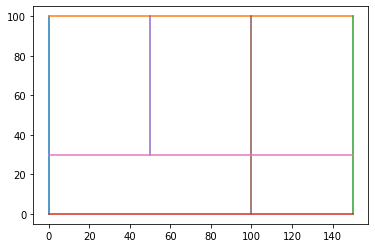

In [ ]:
box.update_inner_walls()
box.plot_outline()

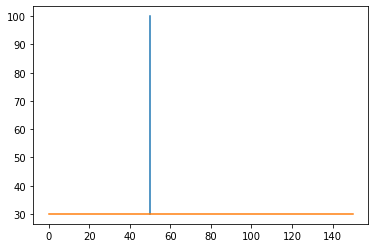

In [ ]:
plot_lines([box.inner_walls[0].base,
box.inner_walls[1].base])

In [ ]:
# När man skapar innerväggen behöver den flytta sig.

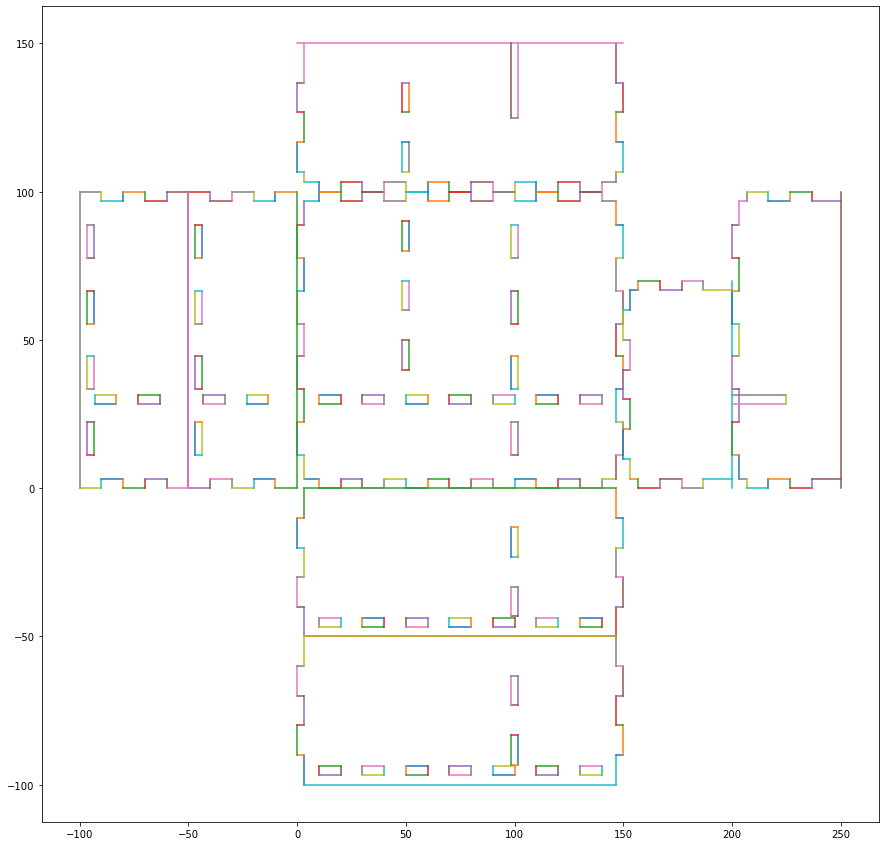

In [ ]:
plt.figure(figsize=(15,15))
box.plot()

In [ ]:
# changing this one too to see if it also need to be chan